Github Repository: https://github.com/amcwhae/DTSA5509-Final-Project

# Predicting Complications for Myocardial Infarctions

Can outcomes (death, various medical complications) be predicted for patients who end up in the ER for myocardial infarctions? The data includes health information up to and including the ER visit and some time afterwards. Knowing early on (i.e. time of admission) which patients are more at risk could lead to their care being prioritized.  

Dataset from http://archive.ics.uci.edu/ml/datasets/Myocardial+infarction+complications

## Notes about dataset
* Columns 2-112 can be used for prediction
    * Use all except 93, 94, 95, 100, 101, 102, 103, 104, 105 for time of admission to hospital
* Columns 113-124 are complications (outputs)

In [192]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score

# Data

Import data and inspect dimensions

In [193]:
data = pd.read_csv("MI.data", sep=",")
data.shape

(1699, 124)

* 1699 observations, 124 variables (1 of which is ID, which is not a variable)

Rename columns nicely

In [194]:
Columns = [
    "ID",
    "Age",
    "genderMale",
    "4. Quantity of myocardial infarctions in the anamnesis (INF_ANAM)",
    "5. Exertional angina pectoris in the anamnesis (STENOK_AN)",
    "6. Functional class (FC) of angina pectoris in the last year (FK_STENOK)",
    "7. Coronary heart disease (CHD) in recent weeks, days before admission to hospital (IBS_POST)",
    "8. Heredity on CHD (IBS_NASL)",
    "9. Presence of an essential hypertension (GB)",
    "10. Symptomatic hypertension (SIM_GIPERT)",
    "11. Duration of arterial hypertension (DLIT_AG)",
    "12. Presence of chronic Heart failure (HF) in the anamnesis (ZSN_A)",
    "13. Observing of arrhythmia in the anamnesis (nr11)",
    "14. Premature atrial contractions in the anamnesis (nr01)",
    "15. Premature ventricular contractions in the anamnesis (nr02)",
    "16. Paroxysms of atrial fibrillation in the anamnesis (nr03)",
    "17. A persistent form of atrial fibrillation in the anamnesis (nr04)",
    "18. Ventricular fibrillation in the anamnesis (nr07)",
    "19. Ventricular paroxysmal tachycardia in the anamnesis (nr08)",
    "20. First-degree AV block in the anamnesis (np01)",
    "21. Third-degree AV block in the anamnesis (np04)",
    "22. LBBB (anterior branch) in the anamnesis (np05)",
    "23. Incomplete LBBB in the anamnesis (np07)",
    "24. Complete LBBB in the anamnesis (np08)",
    "25. Incomplete RBBB in the anamnesis (np09)",
    "26. Complete RBBB in the anamnesis (np10)",
    "27. Diabetes mellitus in the anamnesis (endocr_01)",
    "28. Obesity in the anamnesis (endocr_02)",
    "29. Thyrotoxicosis in the anamnesis (endocr_03)",
    "30. Chronic bronchitis in the anamnesis (zab_leg_01)",
    "31. Obstructive chronic bronchitis in the anamnesis (zab_leg_02)",
    "32. Bronchial asthma in the anamnesis (zab_leg_03)",
    "33. Chronic pneumonia in the anamnesis (zab_leg_04)",
    "34. Pulmonary tuberculosis in the anamnesis (zab_leg_06)",
    "35. Systolic blood pressure according to Emergency Cardiology Team (S_AD_KBRIG) (mmHg)",
    "36. Diastolic blood pressure according to Emergency Cardiology Team (D_AD_KBRIG) (mmHg)",
    "37. Systolic blood pressure according to intensive care unit (S_AD_ORIT) (mmHg)",
    "38. Diastolic blood pressure according to intensive care unit (D_AD_ORIT) (mmHg)",
    "39. Pulmonary edema at the time of admission to intensive care unit (O_L_POST)",
    "40. Cardiogenic shock at the time of admission to intensive care unit (K_SH_POST)",
    "41. Paroxysms of atrial fibrillation at the time of admission to intensive care unit, (or at a pre-hospital stage) (MP_TP_POST)",
    "42. Paroxysms of supraventricular tachycardia at the time of admission to intensive care unit, (or at a pre-hospital stage) (SVT_POST)",
    "43. Paroxysms of ventricular tachycardia at the time of admission to intensive care unit, (or at a pre-hospital stage) (GT_POST)",
    "44. Ventricular fibrillation at the time of admission to intensive care unit, (or at a pre-hospital stage) (FIB_G_POST)",
    "45. Presence of an anterior myocardial infarction (left ventricular) (ECG changes in leads V1: V4 ) (ant_im)",
    "46. Presence of a lateral myocardial infarction (left ventricular) (ECG changes in leads V5: V6 , I, AVL) (lat_im)",
    "47. Presence of an inferior myocardial infarction (left ventricular) (ECG changes in leads III, AVF, II). (inf_im)",
    "48. Presence of a posterior myocardial infarction (left ventricular) (ECG changes in V7: V9, reciprocity changes in leads V1 â€“ V3) (post_im)",
    "49. Presence of a right ventricular myocardial infarction (IM_PG_P)",
    "50. ECG rhythm at the time of admission to hospital: sinus (with a heart rate 60-90) (ritm_ecg_p_01)",
    "51. ECG rhythm at the time of admission to hospital: atrial fibrillation (ritm_ecg_p_02)",
    "52. ECG rhythm at the time of admission to hospital: atrial (ritm_ecg_p_04)",
    "53. ECG rhythm at the time of admission to hospital: idioventricular (ritm_ecg_p_06)",
    "54. ECG rhythm at the time of admission to hospital: sinus with a heart rate above 90 (tachycardia) (ritm_ecg_p_07)",
    "55. ECG rhythm at the time of admission to hospital: sinus with a heart rate below 60 (bradycardia) (ritm_ecg_p_08)",
    "56. Premature atrial contractions on ECG at the time of admission to hospital (n_r_ecg_p_01)",
    "57. Frequent premature atrial contractions on ECG at the time of admission to hospital (n_r_ecg_p_02)",
    "58. Premature ventricular contractions on ECG at the time of admission to hospital (n_r_ecg_p_03)",
    "59. Frequent premature ventricular contractions on ECG at the time of admission to hospital (n_r_ecg_p_04)",
    "60. Paroxysms of atrial fibrillation on ECG at the time of admission to hospital (n_r_ecg_p_05)",
    "61. Persistent form of atrial fibrillation on ECG at the time of admission to hospital (n_r_ecg_p_06)",
    "62. Paroxysms of supraventricular tachycardia on ECG at the time of admission to hospital (n_r_ecg_p_08)",
    "63. Paroxysms of ventricular tachycardia on ECG at the time of admission to hospital (n_r_ecg_p_09)",
    "64. Ventricular fibrillation on ECG at the time of admission to hospital (n_r_ecg_p_10)",
    "65. Sinoatrial block on ECG at the time of admission to hospital (n_p_ecg_p_01)",
    "66. First-degree AV block on ECG at the time of admission to hospital (n_p_ecg_p_03)",
    "67. Type 1 Second-degree AV block (Mobitz I/Wenckebach) on ECG at the time of admission to hospital (n_p_ecg_p_04)",
    "68. Type 2 Second-degree AV block (Mobitz II/Hay) on ECG at the time of admission to hospital (n_p_ecg_p_05)",
    "69. Third-degree AV block on ECG at the time of admission to hospital (n_p_ecg_p_06)",
    "70. LBBB (anterior branch) on ECG at the time of admission to hospital (n_p_ecg_p_07)",
    "71. LBBB (posterior branch) on ECG at the time of admission to hospital (n_p_ecg_p_08)",
    "72. Incomplete LBBB on ECG at the time of admission to hospital (n_p_ecg_p_09)",
    "73. Complete LBBB on ECG at the time of admission to hospital (n_p_ecg_p_10)",
    "74. Incomplete RBBB on ECG at the time of admission to hospital (n_p_ecg_p_11)",
    "75. Complete RBBB on ECG at the time of admission to hospital (n_p_ecg_p_12):",
    "76. Fibrinolytic therapy by Ð¡Ðµliasum 750k IU (fibr_ter_01)",
    "77. Fibrinolytic therapy by Ð¡Ðµliasum 1m IU (fibr_ter_02)",
    "78. Fibrinolytic therapy by Ð¡Ðµliasum 3m IU (fibr_ter_03)",
    "79. Fibrinolytic therapy by Streptase (fibr_ter_05)",
    "80. Fibrinolytic therapy by Ð¡Ðµliasum 500k IU (fibr_ter_06)",
    "81. Fibrinolytic therapy by Ð¡Ðµliasum 250k IU (fibr_ter_07)",
    "82. Fibrinolytic therapy by Streptodecase 1.5m IU (fibr_ter_08)",
    "83. Hypokalemia ( below 4 mmol/L) (GIPO_K)",
    "84. Serum potassium content (K_BLOOD) (mmol/L)",
    "85 Increase of sodium in serum (more than 150 mmol/L) (GIPER_Na)",
    "86. Serum sodium content (Na_BLOOD) (mmol/L)",
    "87. Serum AlAT content (ALT_BLOOD) (IU/L)",
    "88. Serum AsAT content (AST_BLOOD) (IU/L)",
    "89. Serum CPK content (KFK_BLOOD) (IU/L)",
    "90. White blood cell count (billions per liter) (L_BLOOD)",
    "91. ESR (Erythrocyte sedimentation rate) (ROE) (Ð¼Ð¼)",
    "92. Time elapsed from the beginning of the attack of CHD to the hospital (TIME_B_S)",
    "93. Relapse of the pain in the first hours of the hospital period (R_AB_1_n)",
    "94. Relapse of the pain in the second day of the hospital period (R_AB_2_n)",
    "95. Relapse of the pain in the third day of the hospital period (R_AB_3_n)",
    "96. Use of opioid drugs by the Emergency Cardiology Team (NA_KB)",
    "97. Use of NSAIDs by the Emergency Cardiology Team (NOT_NA_KB)",
    "98. Use of lidocaine by the Emergency Cardiology Team (LID_KB)",
    "99. Use of liquid nitrates in the ICU (NITR_S)",
    "100. Use of opioid drugs in the ICU in the first hours of the hospital period (NA_R_1_n)",
    "101. Use of opioid drugs in the ICU in the second day of the hospital period (NA_R_2_n)",
    "102. Use of opioid drugs in the ICU in the third day of the hospital period (NA_R_3_n)",
    "103. Use of NSAIDs in the ICU in the first hours of the hospital period (NOT_NA_1_n)",
    "104. Use of NSAIDs in the ICU in the second day of the hospital period (NOT_NA_2_n)",
    "105. Use of NSAIDs in the ICU in the third day of the hospital period (NOT_NA_3_n)",
    "106. Use of lidocaine in the ICU (LID_S_n)",
    "107. Use of beta-blockers in the ICU (B_BLOK_S_n)",
    "108. Use of calcium channel blockers in the ICU (ANT_CA_S_n)",
    "109. Use of Ð° anticoagulants (heparin) in the ICU (GEPAR_S_n)",
    "110. Use of acetylsalicylic acid in the ICU (ASP_S_n)",
    "111. Use of Ticlid in the ICU (TIKL_S_n)",
    "112. Use of Trental in the ICU (TRENT_S_n)",
    "113. Atrial fibrillation (FIBR_PREDS)",
    "114. Supraventricular tachycardia (PREDS_TAH)",
    "115. Ventricular tachycardia (JELUD_TAH)",
    "116. Ventricular fibrillation (FIBR_JELUD)",
    "117. Third-degree AV block (A_V_BLOK)",
    "118. Pulmonary edema (OTEK_LANC)",
    "119. Myocardial rupture (RAZRIV)",
    "120. Dressler syndrome (DRESSLER)",
    "121. Chronic heart failure (ZSN)",
    "122. Relapse of the myocardial infarction (REC_IM)",
    "123. Post-infarction angina (P_IM_STEN)",
    "124. Lethal outcome (cause) (LET_IS)"
]
data.columns = Columns
data.head()

,ID,Age,genderMale,4. Quantity of myocardial infarctions in the anamnesis (INF_ANAM),5. Exertional angina pectoris in the anamnesis (STENOK_AN),6. Functional class (FC) of angina pectoris in the last year (FK_STENOK),"7. Coronary heart disease (CHD) in recent weeks, days before admission to hospital (IBS_POST)",8. Heredity on CHD (IBS_NASL),9. Presence of an essential hypertension (GB),10. Symptomatic hypertension (SIM_GIPERT),...,115. Ventricular tachycardia (JELUD_TAH),116. Ventricular fibrillation (FIBR_JELUD),117. Third-degree AV block (A_V_BLOK),118. Pulmonary edema (OTEK_LANC),119. Myocardial rupture (RAZRIV),120. Dressler syndrome (DRESSLER),121. Chronic heart failure (ZSN),122. Relapse of the myocardial infarction (REC_IM),123. Post-infarction angina (P_IM_STEN),124. Lethal outcome (cause) (LET_IS)
0,2,55,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,52,1,0,0,0,2,?,2,0,...,0,0,0,0,0,0,0,0,0,0
2,4,68,0,0,0,0,2,?,2,0,...,0,0,0,0,0,0,1,0,0,0
3,5,60,1,0,0,0,2,?,3,0,...,0,0,0,0,0,0,0,0,0,0
4,6,64,1,0,1,2,1,?,0,0,...,0,0,0,0,0,0,0,0,0,0


* 124 columns
    * 12 dependent variables (outcomes)
    * 111 independent variables (predictors)
    * 1 is just ID

In [195]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1699 entries, 0 to 1698
Columns: 124 entries, ID to 124. Lethal outcome (cause) (LET_IS)
dtypes: int64(14), object(110)
memory usage: 1.6+ MB


# Data Cleaning

Some of the columns contain values that are objects but should be numeric, so let's change them.

In [196]:
# change to numeric in case it isn't already
for column in data.columns:
    data[column] = pd.to_numeric(data[column],errors='coerce')

data.head()

,ID,Age,genderMale,4. Quantity of myocardial infarctions in the anamnesis (INF_ANAM),5. Exertional angina pectoris in the anamnesis (STENOK_AN),6. Functional class (FC) of angina pectoris in the last year (FK_STENOK),"7. Coronary heart disease (CHD) in recent weeks, days before admission to hospital (IBS_POST)",8. Heredity on CHD (IBS_NASL),9. Presence of an essential hypertension (GB),10. Symptomatic hypertension (SIM_GIPERT),...,115. Ventricular tachycardia (JELUD_TAH),116. Ventricular fibrillation (FIBR_JELUD),117. Third-degree AV block (A_V_BLOK),118. Pulmonary edema (OTEK_LANC),119. Myocardial rupture (RAZRIV),120. Dressler syndrome (DRESSLER),121. Chronic heart failure (ZSN),122. Relapse of the myocardial infarction (REC_IM),123. Post-infarction angina (P_IM_STEN),124. Lethal outcome (cause) (LET_IS)
0,2,55.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,3,52.0,1,0.0,0.0,0.0,2.0,NaN,2.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,4,68.0,0,0.0,0.0,0.0,2.0,NaN,2.0,0.0,...,0,0,0,0,0,0,1,0,0,0
3,5,60.0,1,0.0,0.0,0.0,2.0,NaN,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,6,64.0,1,0.0,1.0,2.0,1.0,NaN,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


* Drop any columns that are 25% NaN
* Fill remaining NaN with median (not mean since a lot of columns are categorial 0-1 or 0-n and data is skewed)
* Select only first day data
* Separate predictors from outcomes

In [197]:
# print(data)
# data = data.replace("?", np.nan)

cleaned_data = data.dropna(axis=1, how='all', thresh=len(data)*0.25) # Note this removes columns

cleaned_data = cleaned_data.fillna(cleaned_data.median())

not_first_day = ["93. Relapse of the pain in the first hours of the hospital period (R_AB_1_n)",
    "94. Relapse of the pain in the second day of the hospital period (R_AB_2_n)",
    "95. Relapse of the pain in the third day of the hospital period (R_AB_3_n)",
    "100. Use of opioid drugs in the ICU in the first hours of the hospital period (NA_R_1_n)",
    "101. Use of opioid drugs in the ICU in the second day of the hospital period (NA_R_2_n)",
    "102. Use of opioid drugs in the ICU in the third day of the hospital period (NA_R_3_n)",
    "103. Use of NSAIDs in the ICU in the first hours of the hospital period (NOT_NA_1_n)",
    "104. Use of NSAIDs in the ICU in the second day of the hospital period (NOT_NA_2_n)",
    "105. Use of NSAIDs in the ICU in the third day of the hospital period (NOT_NA_3_n)"]

predictors = cleaned_data.iloc[:, 1:-12]
predictors = predictors.drop(not_first_day, axis=1)
outcomes = cleaned_data.iloc[:, -12:]

# Exploratory Data Analysis

Let's examine the data

C:\Users\Andrew\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


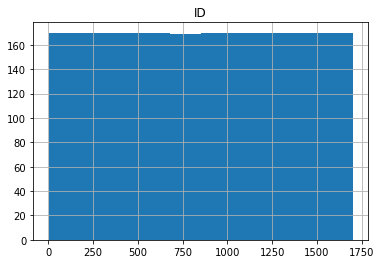

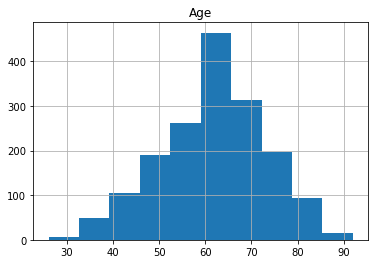

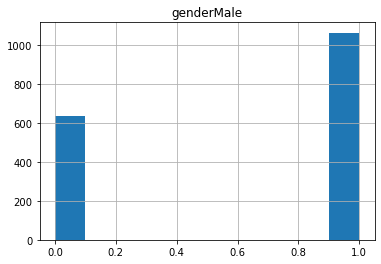

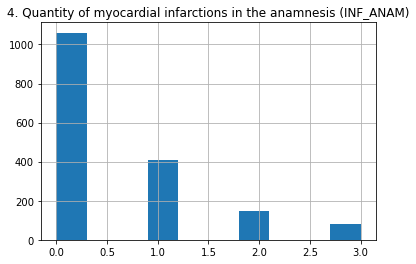

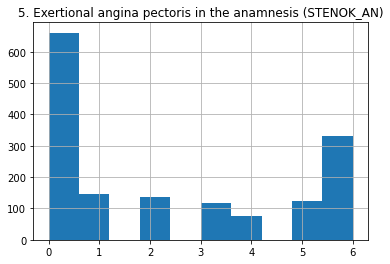

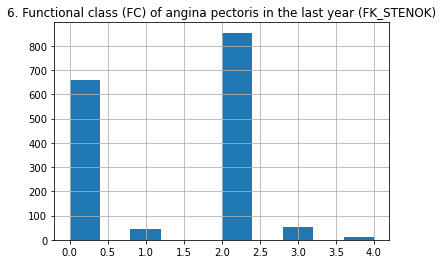

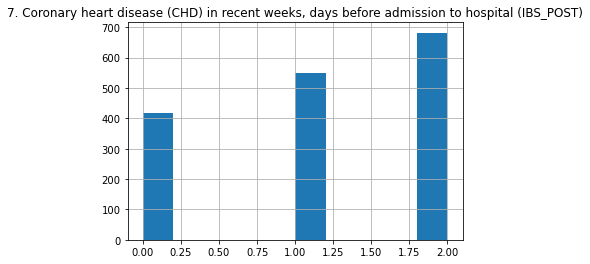

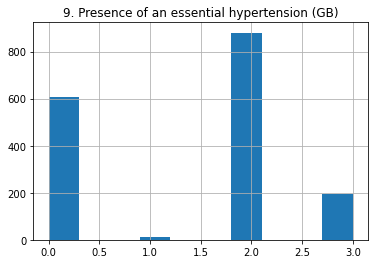

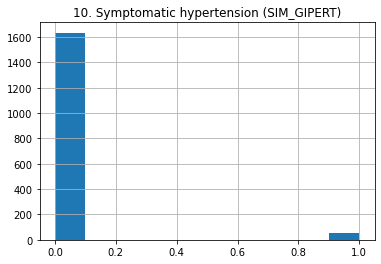

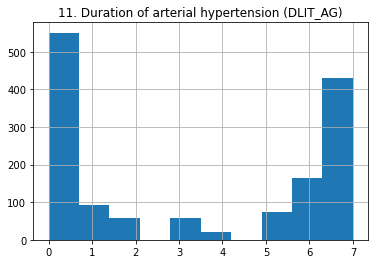

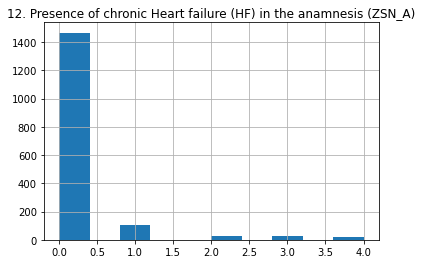

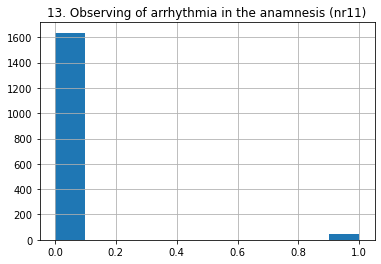

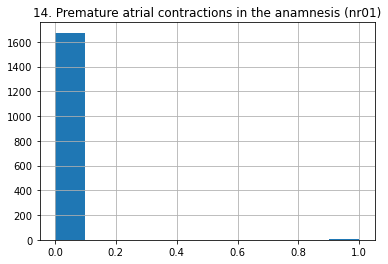

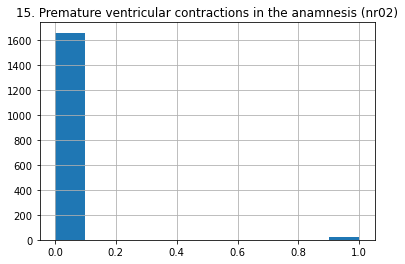

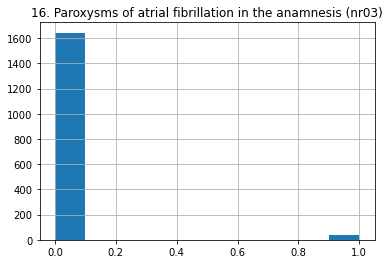

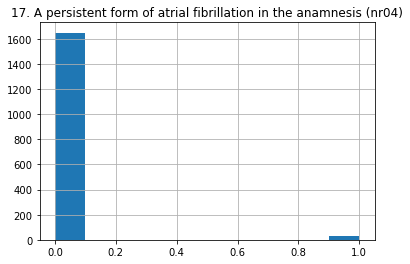

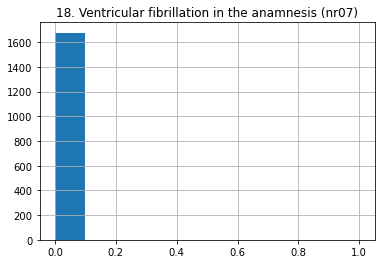

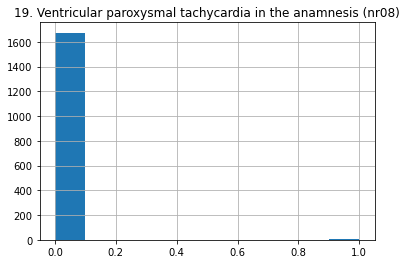

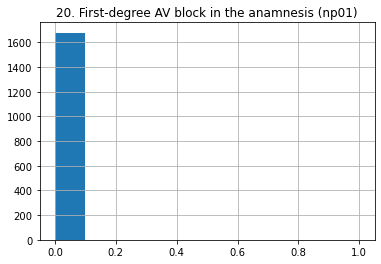

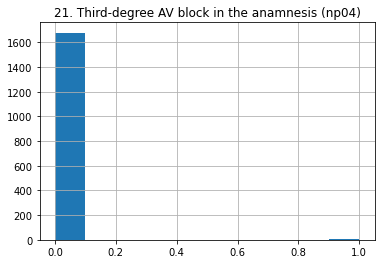

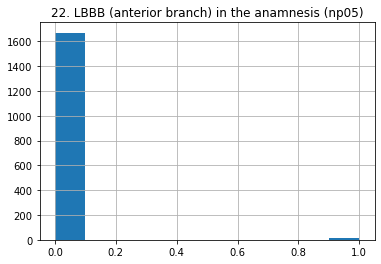

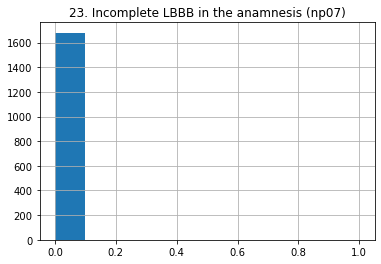

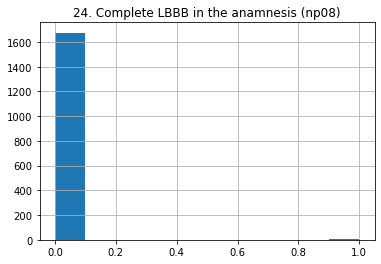

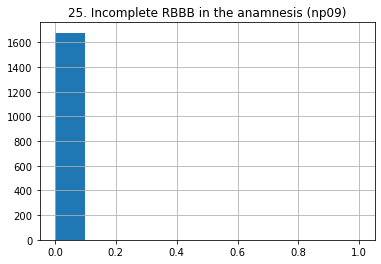

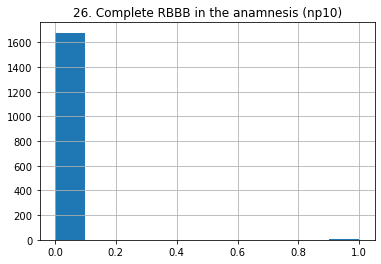

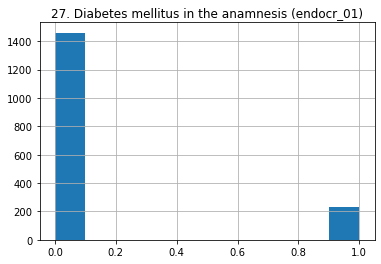

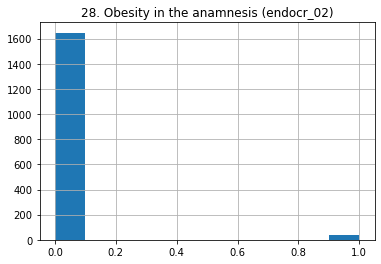

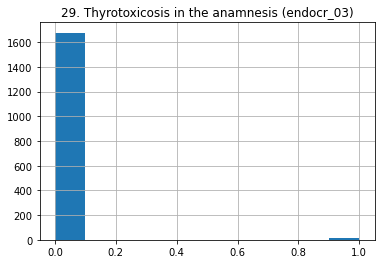

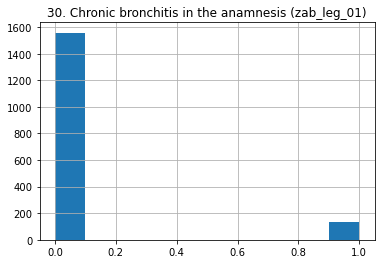

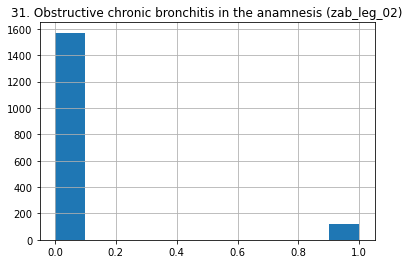

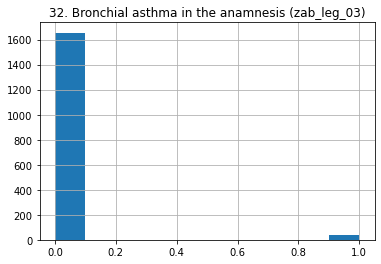

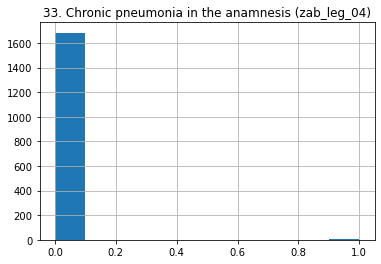

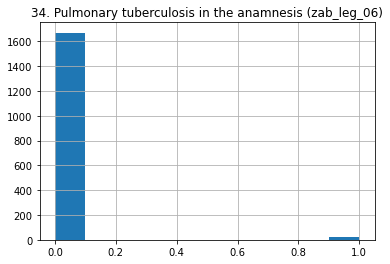

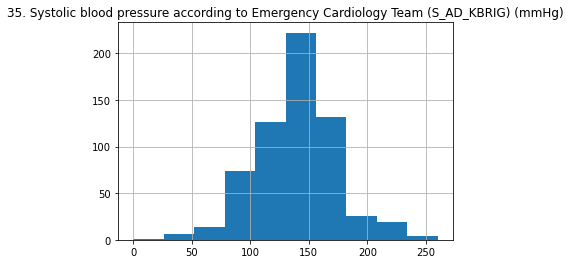

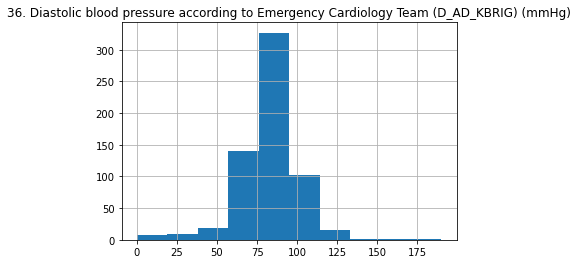

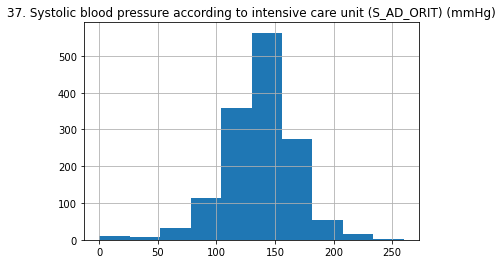

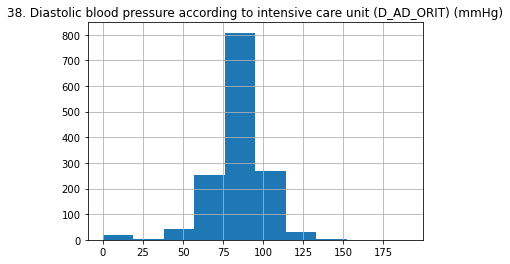

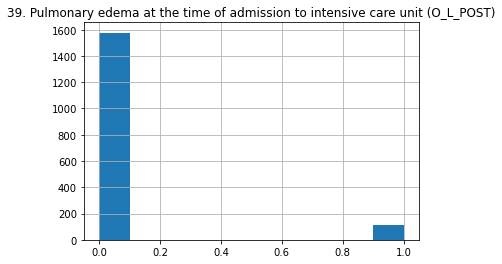

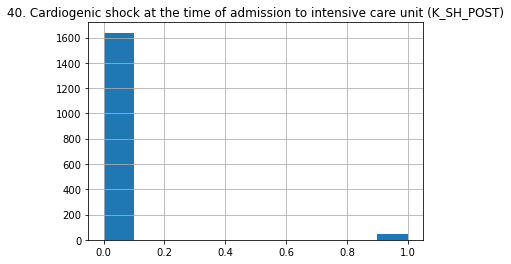

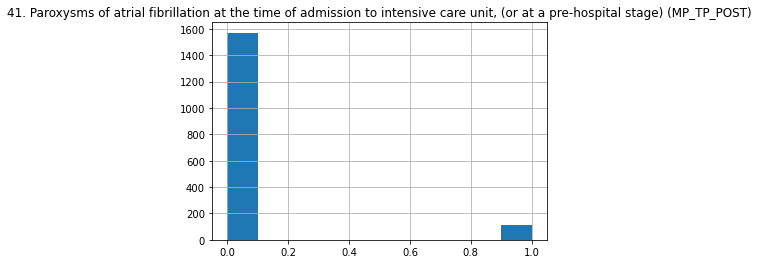

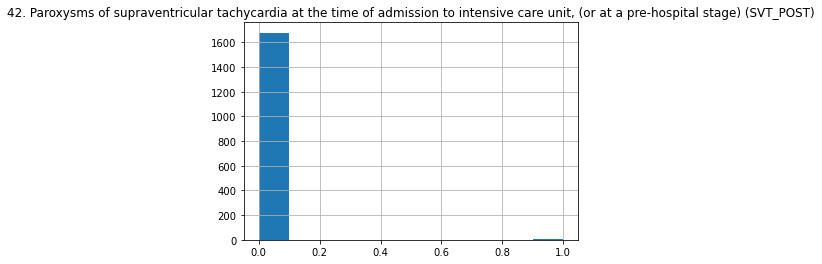

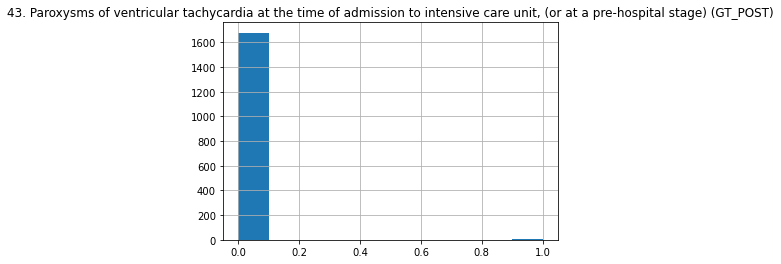

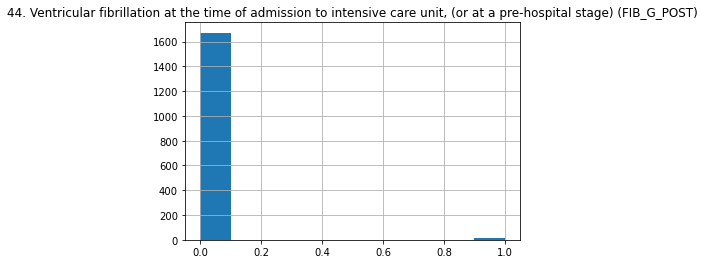

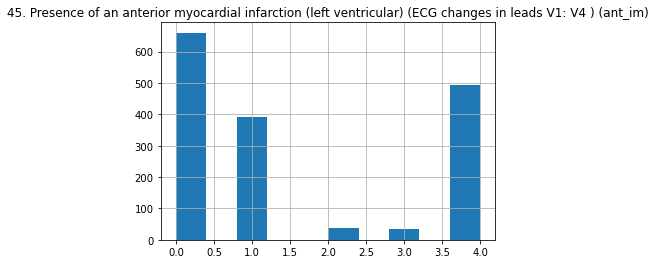

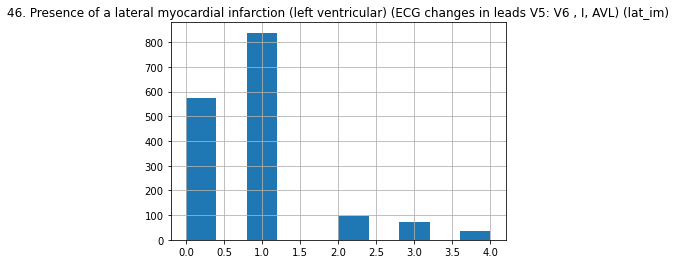

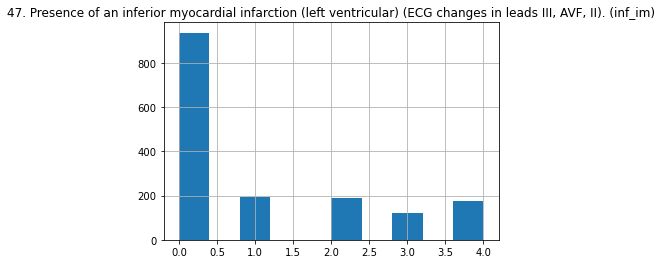

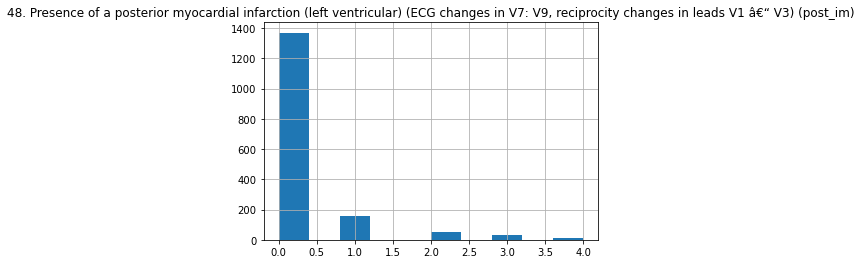

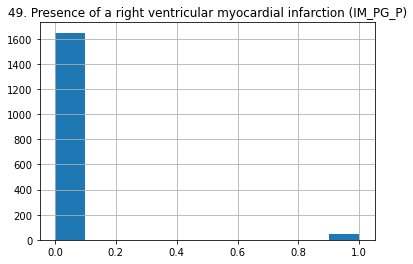

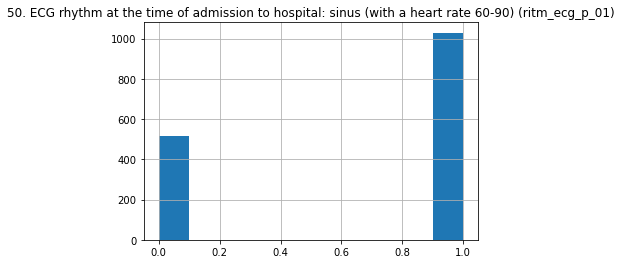

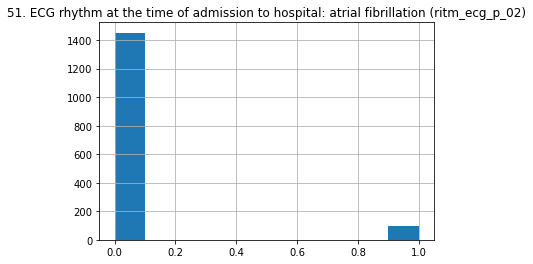

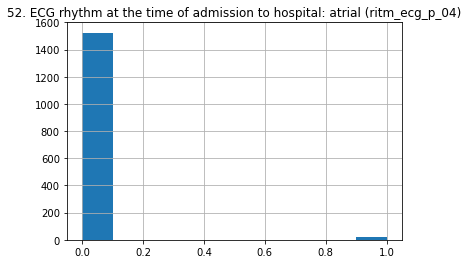

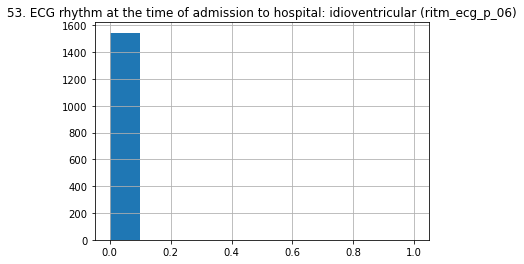

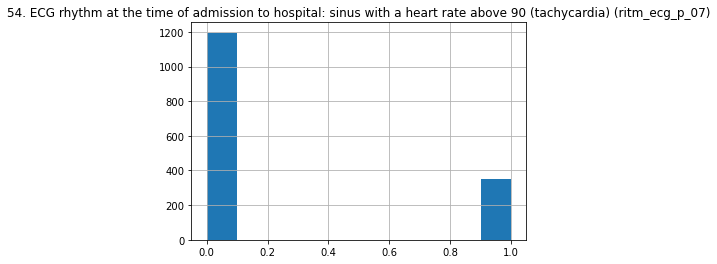

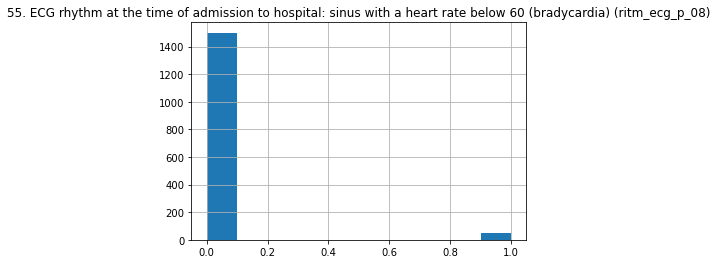

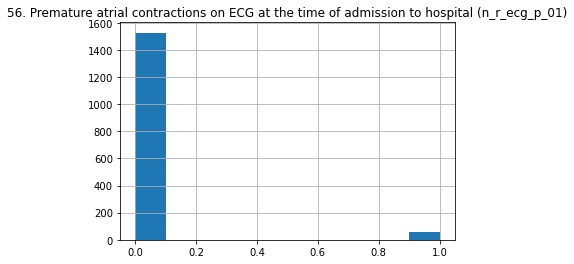

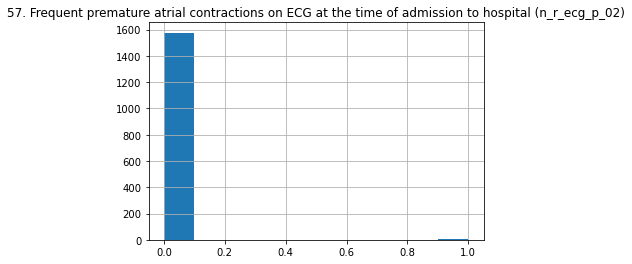

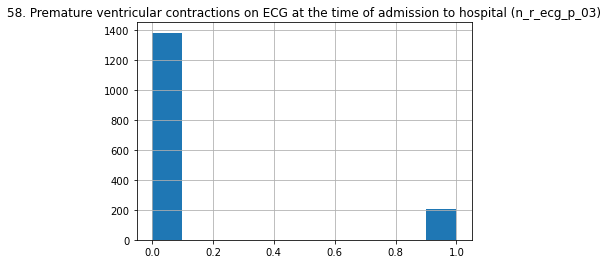

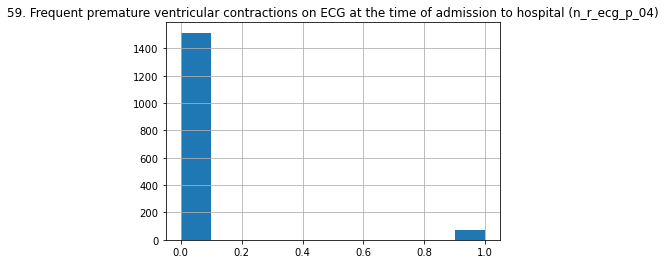

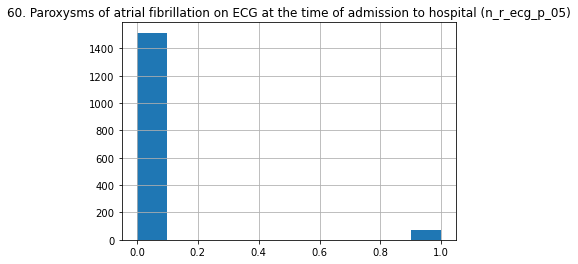

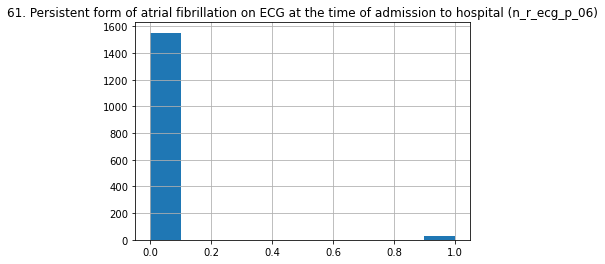

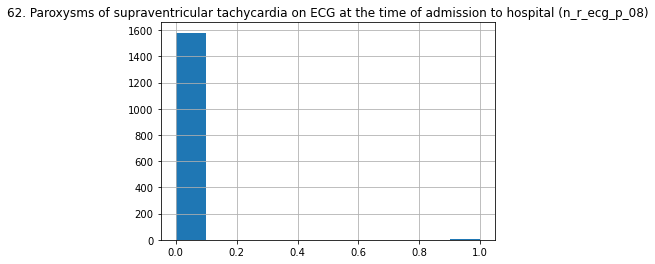

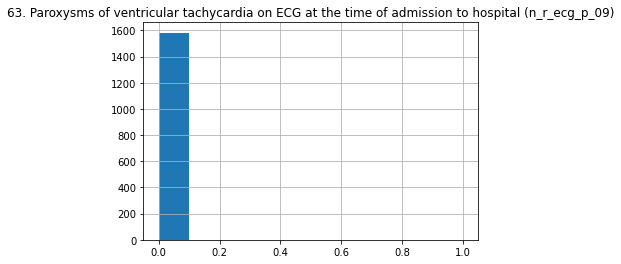

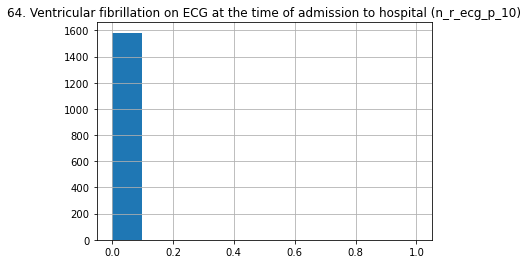

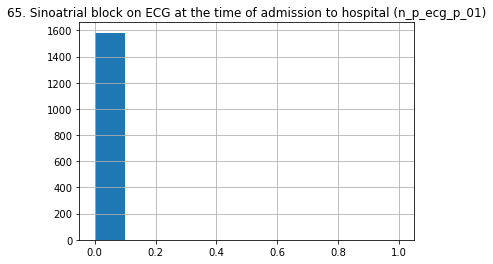

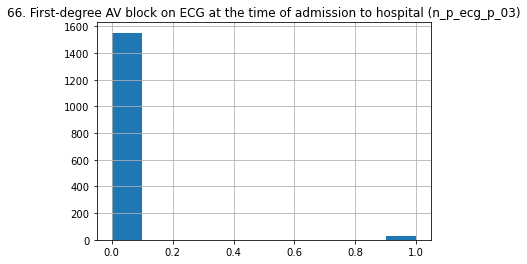

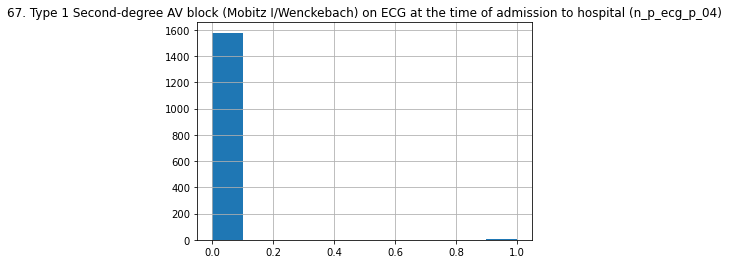

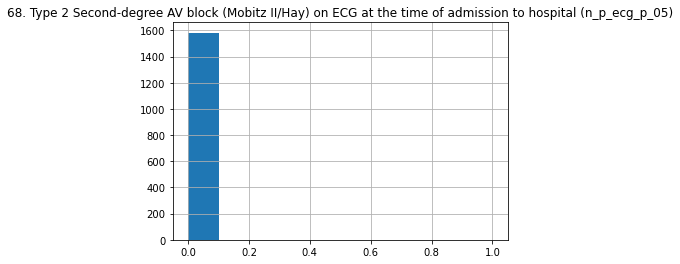

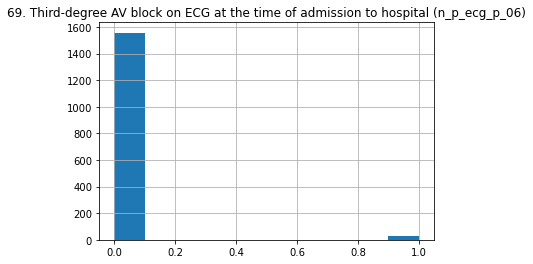

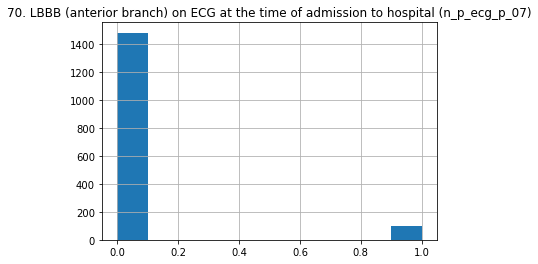

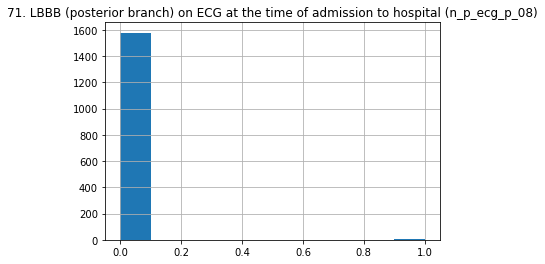

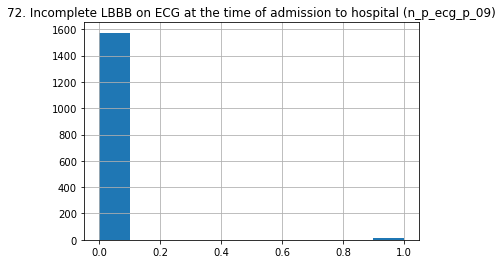

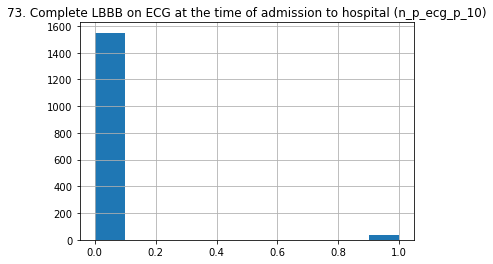

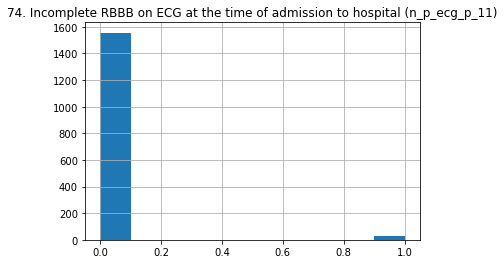

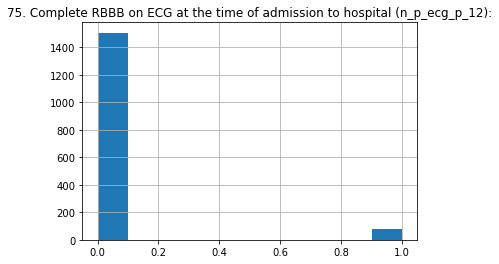

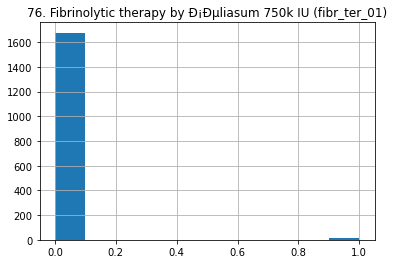

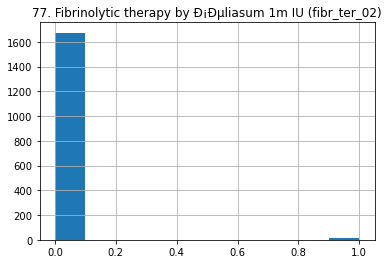

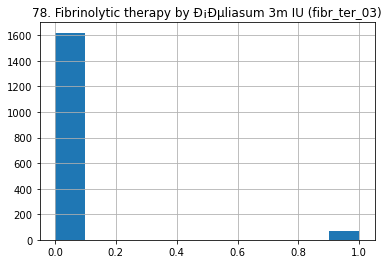

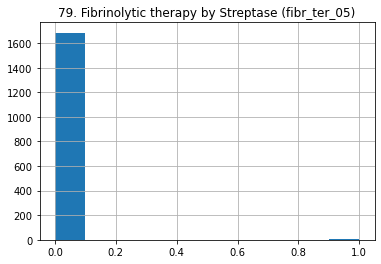

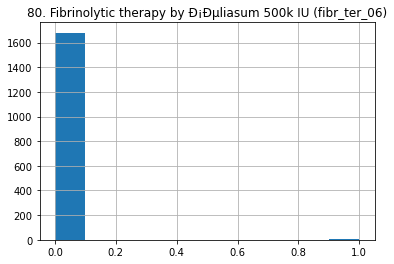

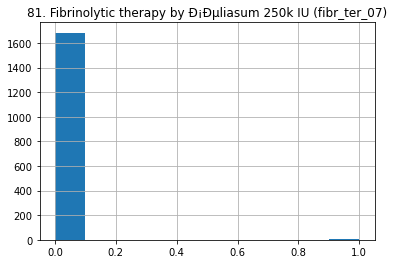

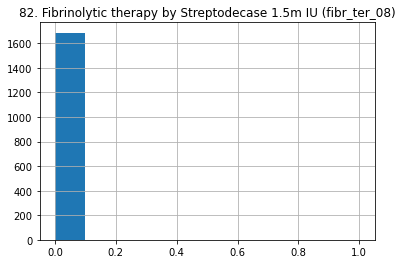

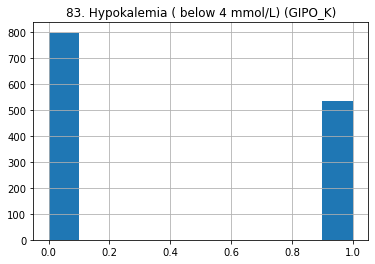

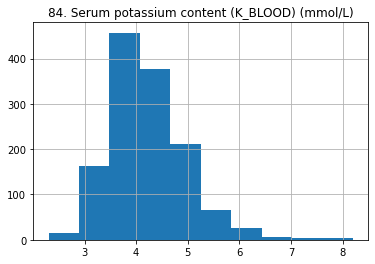

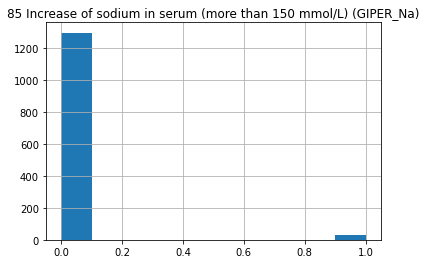

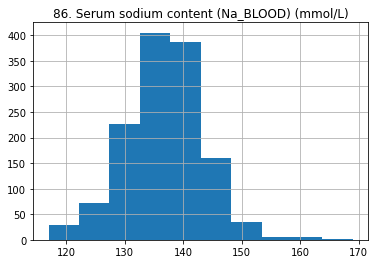

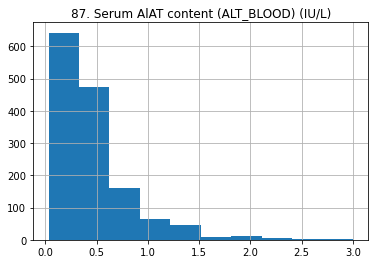

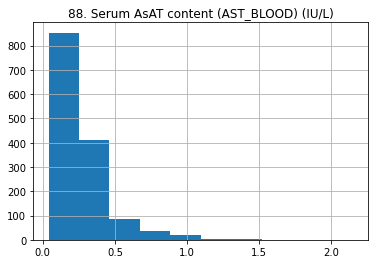

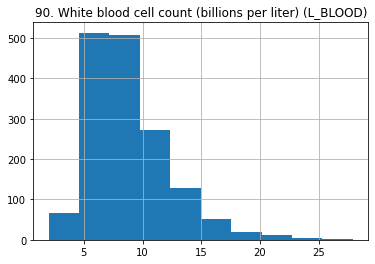

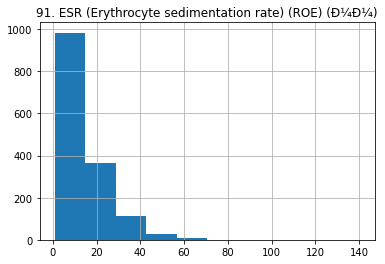

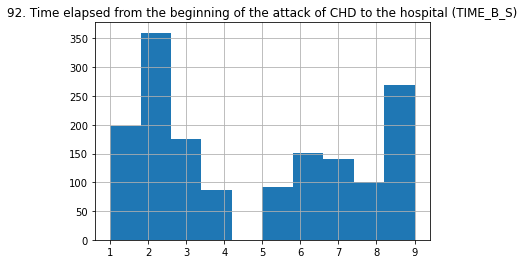

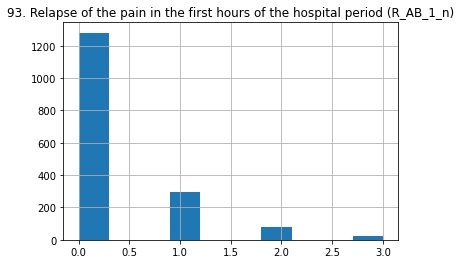

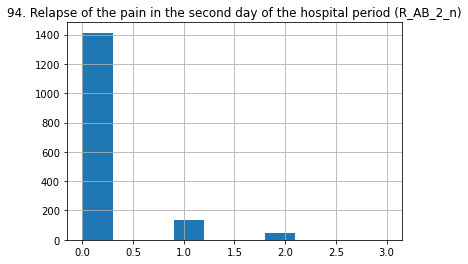

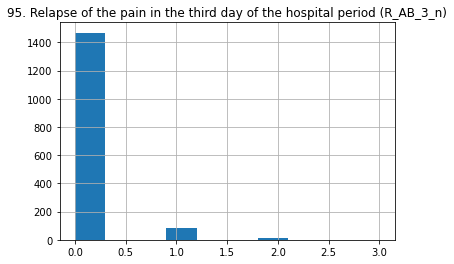

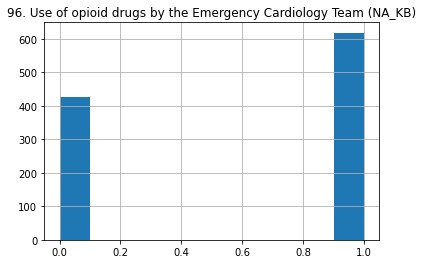

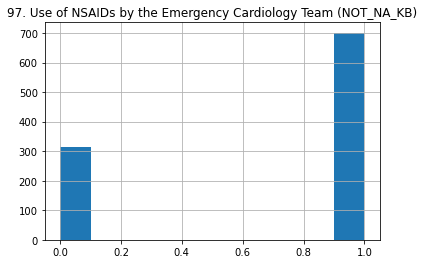

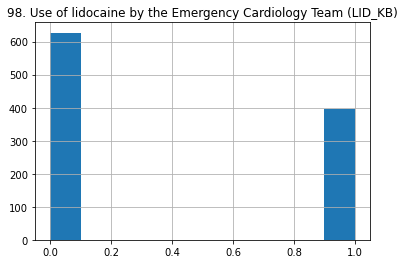

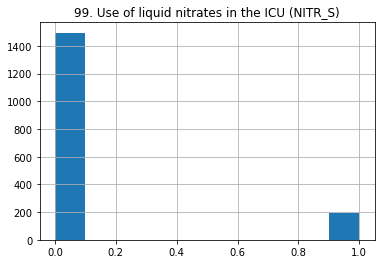

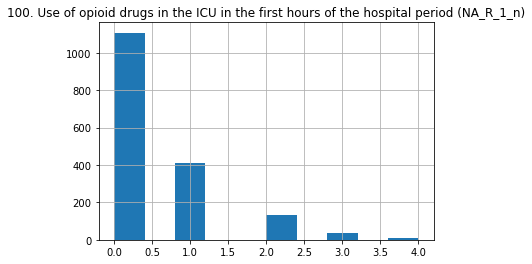

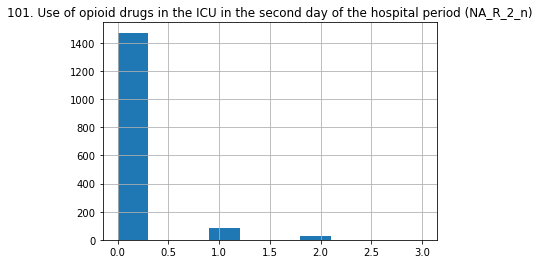

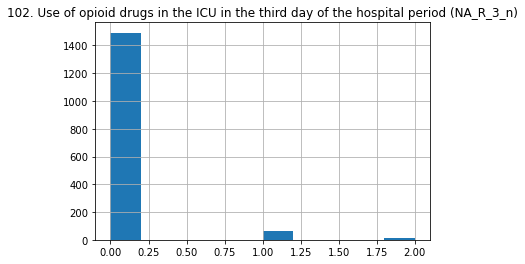

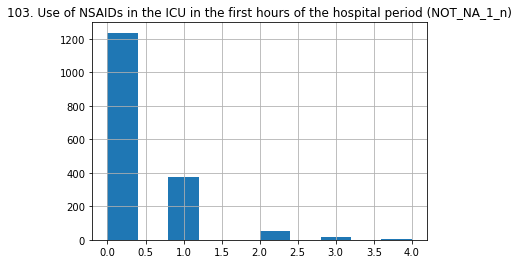

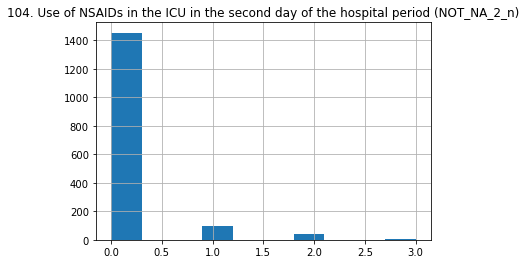

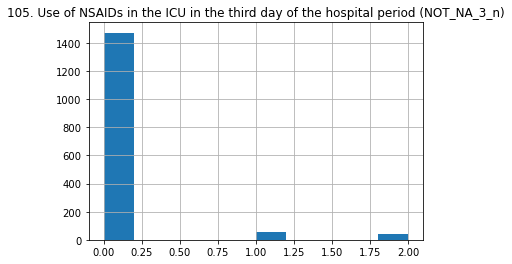

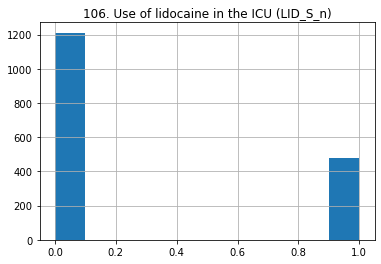

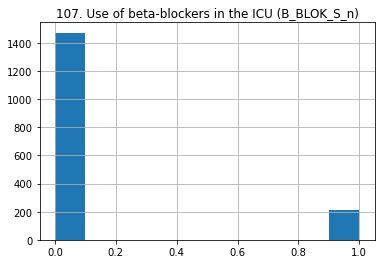

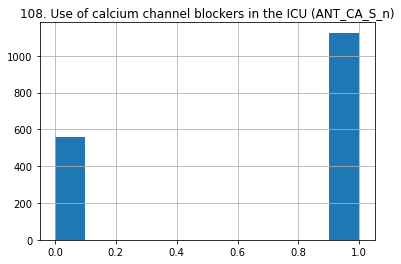

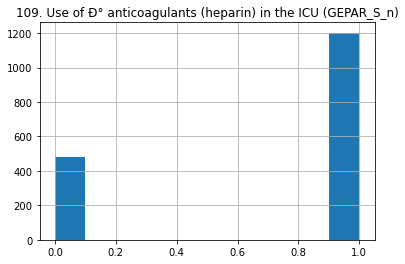

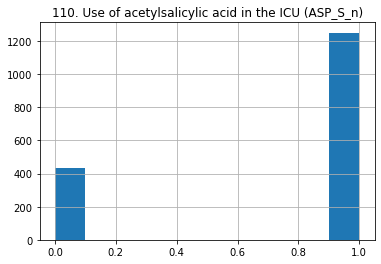

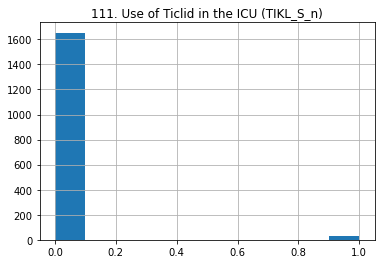

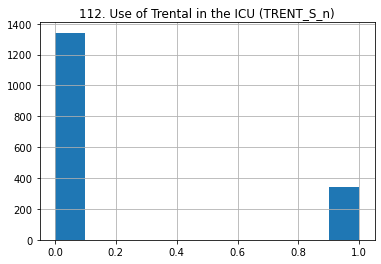

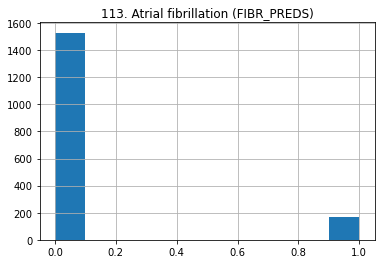

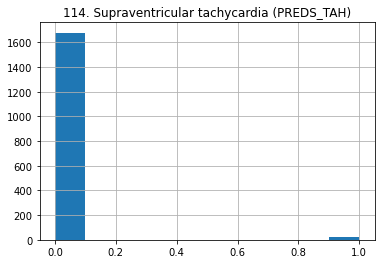

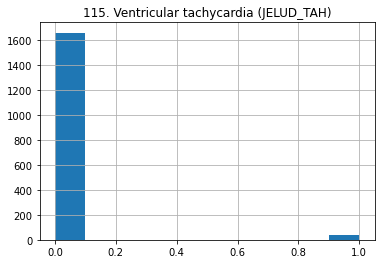

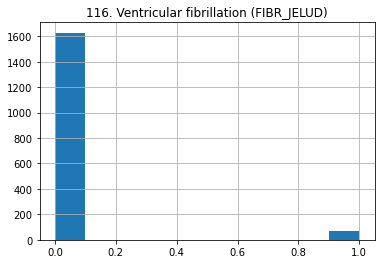

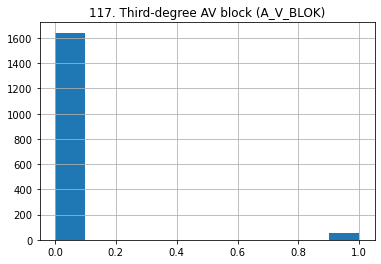

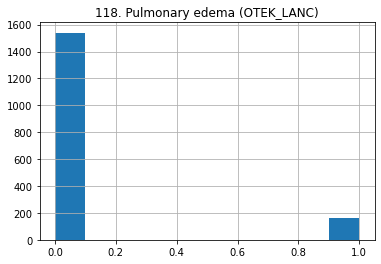

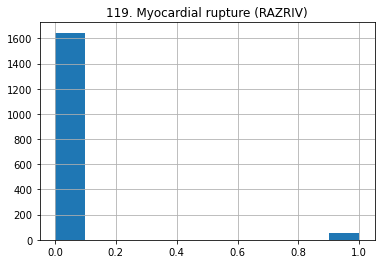

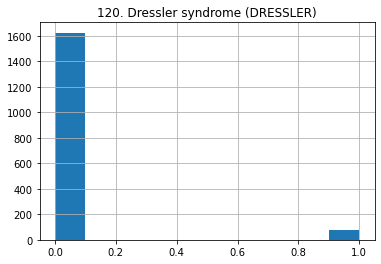

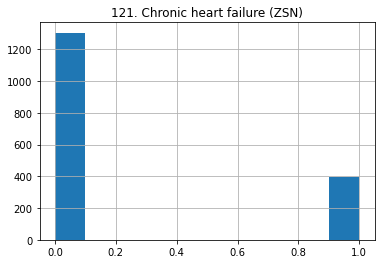

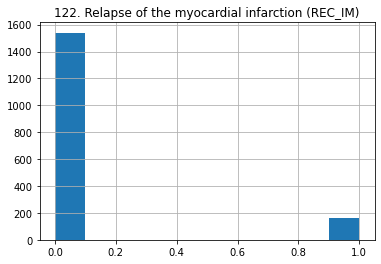

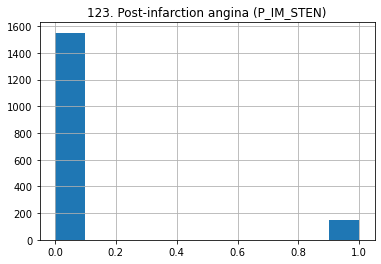

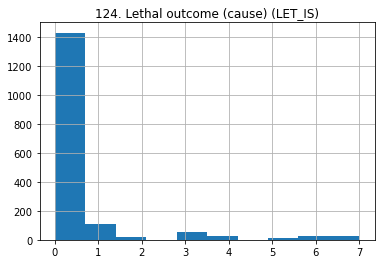

In [198]:
for column in cleaned_data.columns:
    data.hist(column=column)

Age looks normally distributed. Gender is slightly more male. The binary variables all look skewed, some with only 0's. The categorical variables also look skewed. This may cause some problemds later. The numeric variables mostly look normally distributed. 

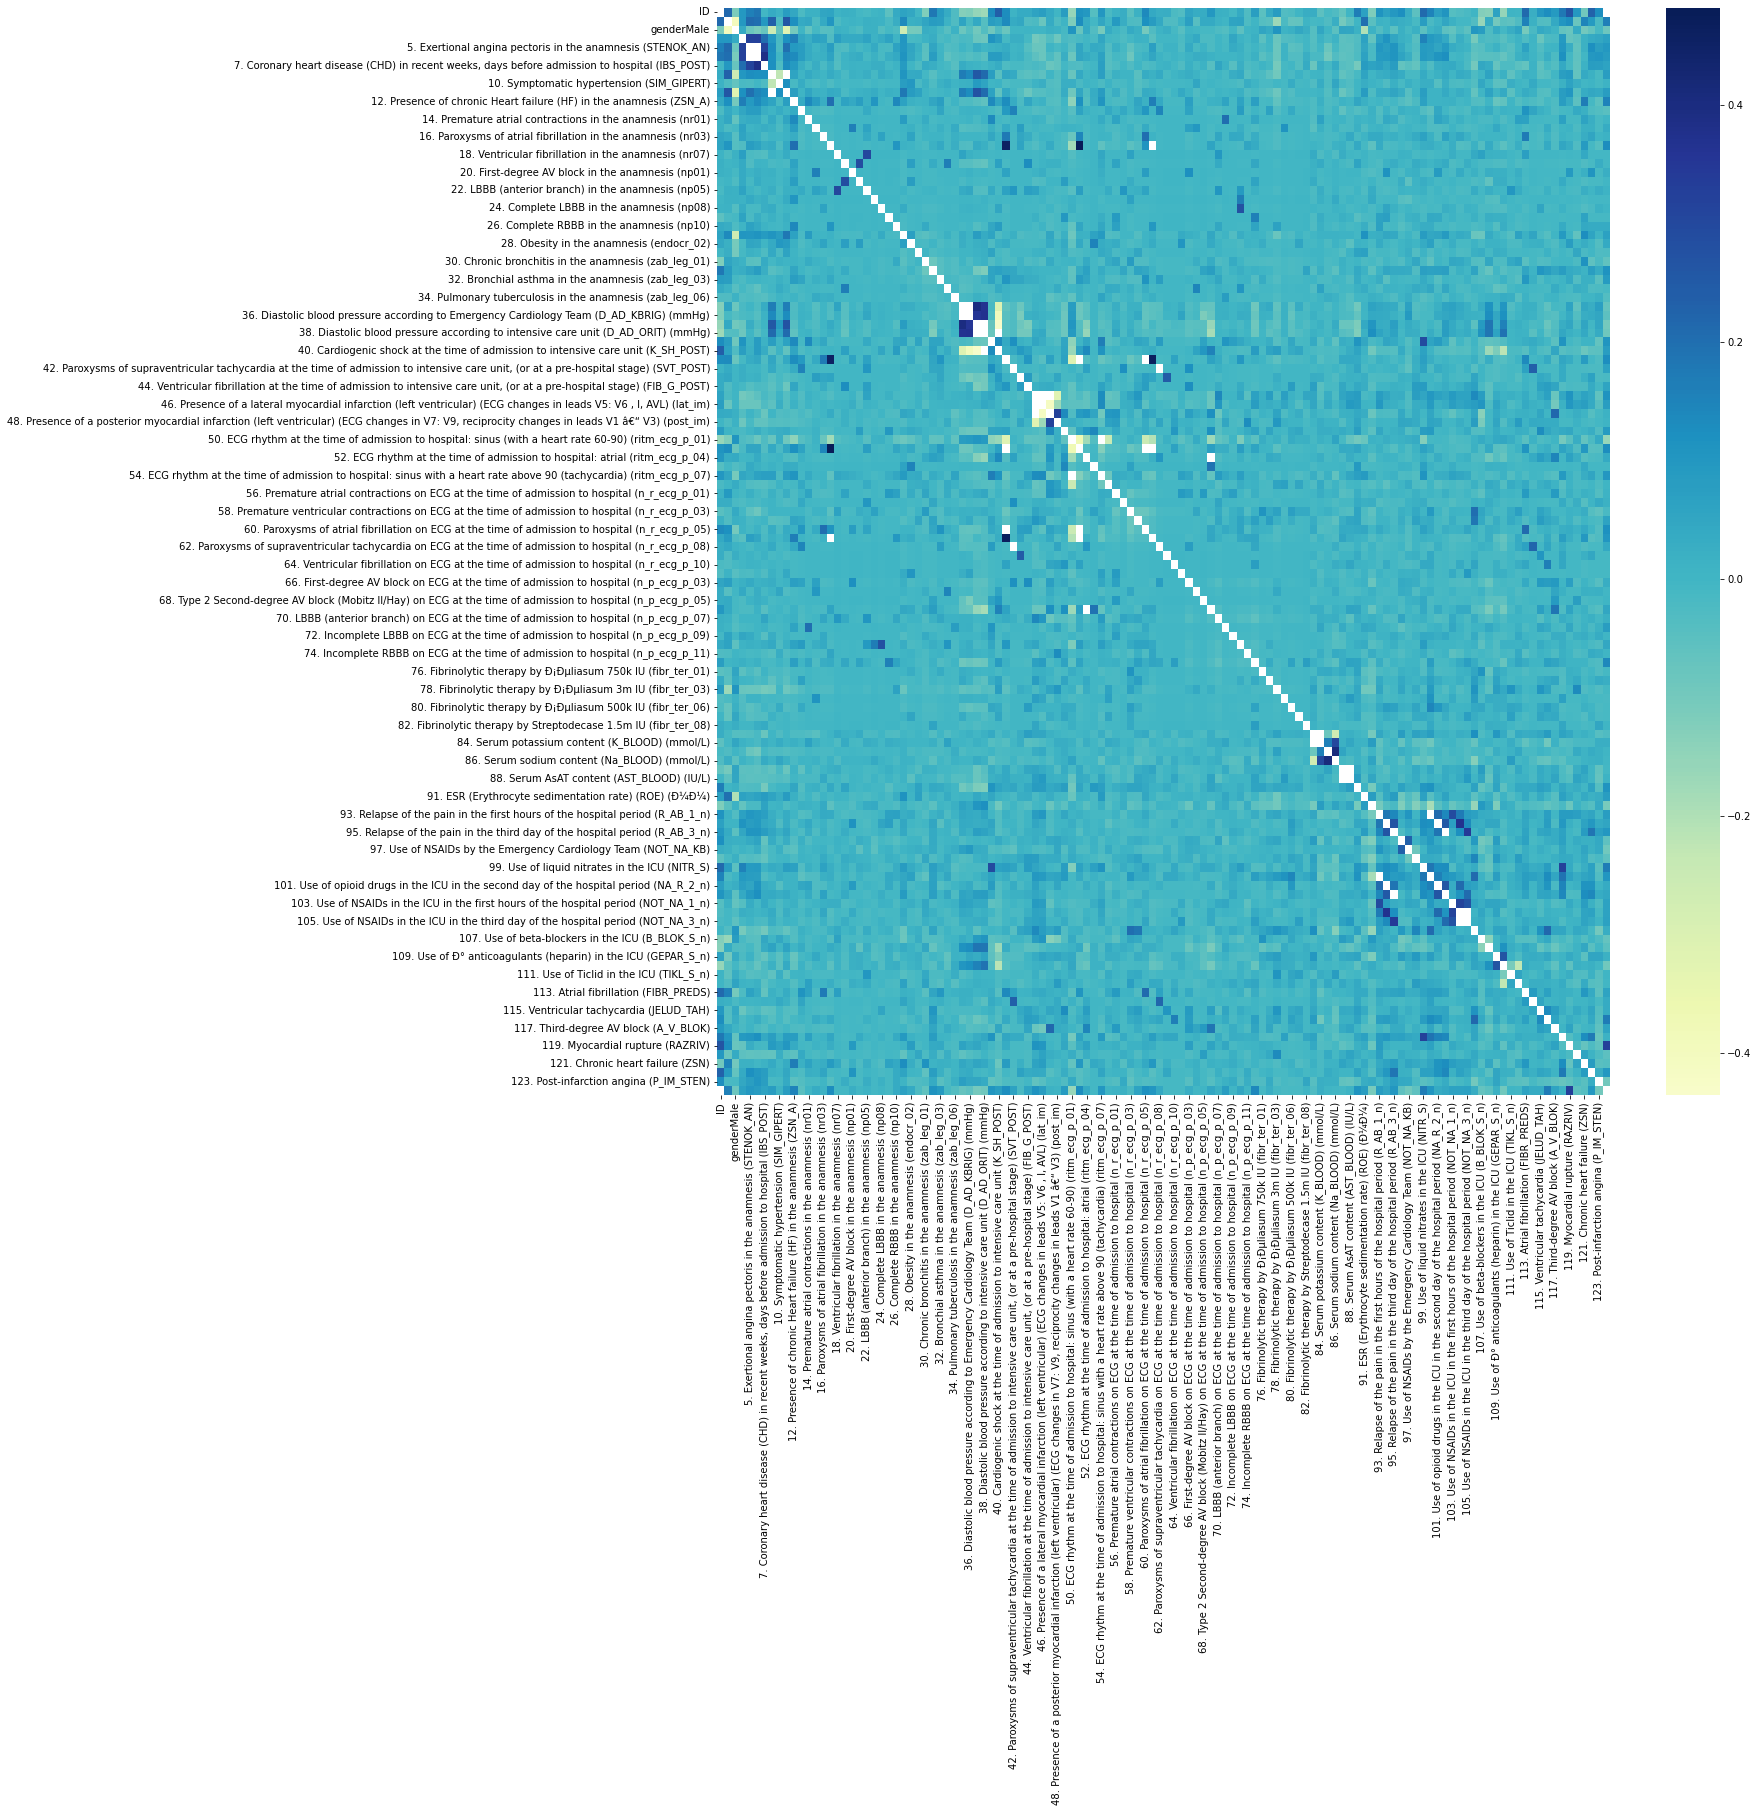

In [199]:
plt.figure(figsize=(20,20))
c = cleaned_data.corr()
sns.heatmap(c, cmap="YlGnBu", mask = (np.abs(c) >= 0.5), center=0) #, vmin = -1, vmax=1) 
plt.show()

It looks like there are some correlated variables (white boxes outside diagonal). Let's see what the values are. The code below will show any correlations above 0.9.

In [200]:
corr_matrix = cleaned_data.corr().abs()
high_corr_var=np.where(corr_matrix>0.9)
high_corr_var=[(corr_matrix.index[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
high_corr_var

[]

There are not feature pairs with a correlation above 0.9, so let's leave them all in the model. 

# Modeling

## Logistic Modeling
* Split into training/testing sets
* Scale data using StandardScaler()
* Run logistic regression on survival and compare accuracy, precision and AOC
* Run logistic repression on all outcomes and compare accuracy, precision and AOC

Accuracy: 0.882
Precision: 0.913
AUC Test: 0.8472


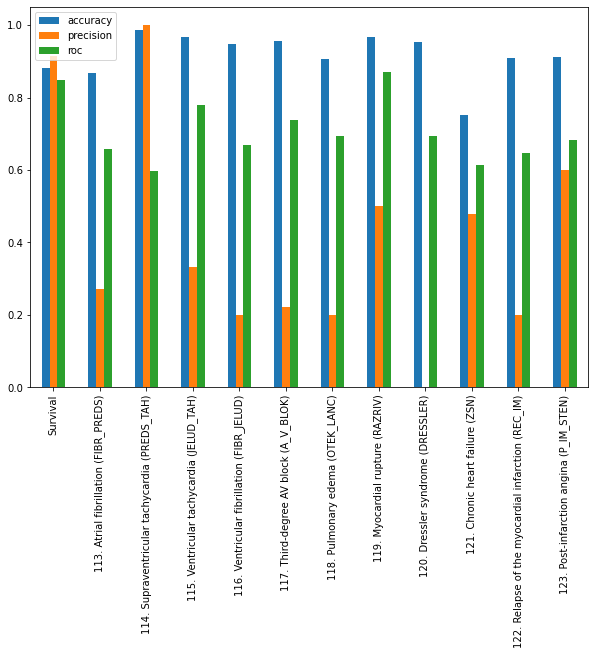

In [201]:
X_train, X_test, y_train, y_test = train_test_split(predictors, np.where(outcomes['124. Lethal outcome (cause) (LET_IS)'] == 0, 1, 0), test_size=0.20, random_state=42)
# pipe = make_pipeline([('scl', StandardScaler()), ('log', LogisticRegression())])
# pipe.fit(X_train, y_train)
from sklearn.pipeline import Pipeline
pipe_log = Pipeline([('scl', StandardScaler()),
                    ('log', LogisticRegression())])
pipe_log.fit(X_train, y_train)

# Accuracy and precision
# print("Survival")
print(f"Accuracy: {pipe_log.score(X_test, y_test):.3f}")
print(f"Precision: {precision_score(y_test, pipe_log.predict(X_test)):.3f}")
outcome_names = ["Survival"]
accuracies = [pipe_log.score(X_test, y_test)]
precisions = [precision_score(y_test, pipe_log.predict(X_test))]

# ROC AOC
y_train_pred = pipe_log.predict_proba(X_train)[:,1]
y_test_pred = pipe_log.predict_proba(X_test)[:,1]
# print(f"AUC Train: {roc_auc_score(y_train, y_train_pred):.4f}")
print(f"AUC Test: {roc_auc_score(y_test, y_test_pred):.4f}")

rocs = [roc_auc_score(y_test, y_test_pred)]

for outcome in outcomes.columns[:-1]:
    X_train_, X_test_, y_train_, y_test_ = train_test_split(predictors, outcomes[outcome].astype(int), test_size=0.20, random_state=42)
    pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=200))
    pipe.fit(X_train_, y_train_)
    # Accuracy and precision
    outcome_names.append(outcome)
    accuracies.append(pipe.score(X_test_, y_test_))
    precisions.append(precision_score(y_test_, pipe.predict(X_test_), zero_division=True))
    rocs.append(roc_auc_score(y_test_, pipe.predict_proba(X_test_)[:,1]))

results = pd.DataFrame({'accuracy':accuracies, 'precision':precisions, 'roc':rocs}, index=outcome_names)
ax = results.plot.bar(figsize=(10,7), rot=90)

For predicting survival, we get an accuracy of 0.882, a precision of 0.913 and an AUC of 0.8472. For the other outcomes, the accuracy is similar, but the AUCs are closer to 0.7 and the precisions are mostly lower. This is probably due to skewed classes and the accuracy is not reasonable to draw conclusions from. 

Let's look at the coefficients of the logistic regression

In [202]:
odds = np.exp(pipe_log.named_steps['log'].coef_)

pd.DataFrame(odds[0], 
             X_train.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

,coef
96. Use of opioid drugs by the Emergency Cardiology Team (NA_KB),1.715218
108. Use of calcium channel blockers in the ICU (ANT_CA_S_n),1.634253
92. Time elapsed from the beginning of the attack of CHD to the hospital (TIME_B_S),1.600809
34. Pulmonary tuberculosis in the anamnesis (zab_leg_06),1.524579
107. Use of beta-blockers in the ICU (B_BLOK_S_n),1.466946
...,...
67. Type 1 Second-degree AV block (Mobitz I/Wenckebach) on ECG at the time of admission to hospital (n_p_ecg_p_04),0.666882
54. ECG rhythm at the time of admission to hospital: sinus with a heart rate above 90 (tachycardia) (ritm_ecg_p_07),0.625072
45. Presence of an anterior myocardial infarction (left ventricular) (ECG changes in leads V1: V4 ) (ant_im),0.613523
9. Presence of an essential hypertension (GB),0.604723


In [203]:
1/0.542096

1.844691715120569

Age was the biggest predictor of outcome (since 1/0.542096 is 1.84, which is the multiplicative effect of a 1-unit increase of age on the odds of not being a survivor). 

## XGBoost Modeling
* Create XGBoost classifier with random hyperparameters

In [204]:
X_train, X_test, y_train, y_test = train_test_split(predictors, np.where(outcomes['124. Lethal outcome (cause) (LET_IS)'] == 0, 1, 0), test_size=0.20, random_state=42)
model_xgboost = xgboost.XGBClassifier(learning_rate=0.1,
                                      max_depth=5,
                                      n_estimators=5000,
                                      subsample=0.5,
                                      colsample_bytree=0.5,
                                      eval_metric='auc',
                                      early_stopping_rounds=10,
                                      verbosity=1)

eval_set = [(X_test, y_test)]
model_xgboost.fit(X_train, y_train, eval_set=eval_set, verbose=True)

[0]	validation_0-auc:0.67501
[1]	validation_0-auc:0.78148
[2]	validation_0-auc:0.80542
[3]	validation_0-auc:0.81968
[4]	validation_0-auc:0.85089
[5]	validation_0-auc:0.85497
[6]	validation_0-auc:0.84342
[7]	validation_0-auc:0.84335
[8]	validation_0-auc:0.86305
[9]	validation_0-auc:0.86882
[10]	validation_0-auc:0.87370
[11]	validation_0-auc:0.87737
[12]	validation_0-auc:0.88495
[13]	validation_0-auc:0.88909
[14]	validation_0-auc:0.88989
[15]	validation_0-auc:0.89056
[16]	validation_0-auc:0.89570
[17]	validation_0-auc:0.89577
[18]	validation_0-auc:0.89597
[19]	validation_0-auc:0.89543
[20]	validation_0-auc:0.89490
[21]	validation_0-auc:0.89490
[22]	validation_0-auc:0.89236
[23]	validation_0-auc:0.89643
[24]	validation_0-auc:0.89430
[25]	validation_0-auc:0.89430
[26]	validation_0-auc:0.89710
[27]	validation_0-auc:0.89690
[28]	validation_0-auc:0.90097
[29]	validation_0-auc:0.89730
[30]	validation_0-auc:0.89824
[31]	validation_0-auc:0.90278
[32]	validation_0-auc:0.90365
[33]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=5000,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

### Hyperparameter Tuning
* Use grid search CV to fine tune hyperparameters

In [205]:
learning_rates = [0.02, 0.05, 0.1]
max_depths = [2, 3, 5]
n_estimators = [1000, 2000, 5000]

params_dict = {"learning_rate": learning_rates,
               "max_depth": max_depths,
               "n_estimators": n_estimators}

In [206]:
def calc_roc_auc_score(model, X, y): return roc_auc_score(y, model.predict_proba(X)[:,1])

model_xgboost_hp = GridSearchCV(estimator=xgboost.XGBClassifier(
    subsample=0.5,
    colsample_bytree=0.25,
    eval_metric='auc',
    use_label_encoder=False),
    param_grid=params_dict,
    cv=2,
    scoring=calc_roc_auc_score,
    return_train_score=True,
    verbose=4)


model_xgboost_hp.fit(predictors, np.where(outcomes['124. Lethal outcome (cause) (LET_IS)'] == 0, 1, 0))


Fitting 2 folds for each of 27 candidates, totalling 54 fits
[CV 1/2] END learning_rate=0.02, max_depth=2, n_estimators=1000;, score=(train=0.982, test=0.843) total time=   0.4s
[CV 2/2] END learning_rate=0.02, max_depth=2, n_estimators=1000;, score=(train=0.979, test=0.867) total time=   0.4s
[CV 1/2] END learning_rate=0.02, max_depth=2, n_estimators=2000;, score=(train=0.995, test=0.847) total time=   0.8s
[CV 2/2] END learning_rate=0.02, max_depth=2, n_estimators=2000;, score=(train=0.996, test=0.867) total time=   0.8s
[CV 1/2] END learning_rate=0.02, max_depth=2, n_estimators=5000;, score=(train=1.000, test=0.844) total time=   2.3s
[CV 2/2] END learning_rate=0.02, max_depth=2, n_estimators=5000;, score=(train=1.000, test=0.855) total time=   2.3s
[CV 1/2] END learning_rate=0.02, max_depth=3, n_estimators=1000;, score=(train=0.997, test=0.852) total time=   0.4s
[CV 2/2] END learning_rate=0.02, max_depth=3, n_estimators=1000;, score=(train=0.997, test=0.873) total time=   0.5s
[CV

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.25,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', gamma=None, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_c...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                        

Show best parameter combinations

In [207]:
df_cv_results = pd.DataFrame(model_xgboost_hp.cv_results_)
df_cv_results = df_cv_results[['rank_test_score','mean_test_score','mean_train_score',
                               'param_learning_rate', 'param_max_depth', 'param_n_estimators']]
df_cv_results.sort_values(by='rank_test_score', inplace=True)
df_cv_results

,rank_test_score,mean_test_score,mean_train_score,param_learning_rate,param_max_depth,param_n_estimators
6,1,0.864118,1.000000,0.02,5,1000
3,2,0.862831,0.997292,0.02,3,1000
7,3,0.857939,1.000000,0.02,5,2000
4,4,0.857873,0.999984,0.02,3,2000
1,5,0.856849,0.995550,0.02,2,2000
12,6,0.856661,1.000000,0.05,3,1000
0,7,0.855259,0.980459,0.02,2,1000
15,8,0.854509,1.000000,0.05,5,1000
9,9,0.853850,0.997787,0.05,2,1000
8,10,0.849917,1.000000,0.02,5,5000


The best parameters were learning_rate = 0.02, max_depth = 5 and n_estimators = 1000.

Create final model with these parameters

In [208]:
model_xgboost_final = xgboost.XGBClassifier(learning_rate=0.02,
                                      max_depth=5,
                                      n_estimators=1000,
                                      subsample=0.5,
                                      colsample_bytree=0.5,
                                      eval_metric='auc',
                                      verbosity=0,
                                      use_label_encoder=False,
                                      early_stopping_rounds=20)
eval_set = [(X_train, y_train),(X_test, y_test)]

model_xgboost_final.fit(X_train, y_train, eval_set=eval_set, verbose=True)

[0]	validation_0-auc:0.79070	validation_1-auc:0.67501
[1]	validation_0-auc:0.84306	validation_1-auc:0.79581
[2]	validation_0-auc:0.86483	validation_1-auc:0.80285
[3]	validation_0-auc:0.86424	validation_1-auc:0.81340
[4]	validation_0-auc:0.87364	validation_1-auc:0.84225
[5]	validation_0-auc:0.87288	validation_1-auc:0.84358
[6]	validation_0-auc:0.86996	validation_1-auc:0.83290
[7]	validation_0-auc:0.88001	validation_1-auc:0.82161
[8]	validation_0-auc:0.88249	validation_1-auc:0.82612
[9]	validation_0-auc:0.88729	validation_1-auc:0.83203
[10]	validation_0-auc:0.89331	validation_1-auc:0.84071
[11]	validation_0-auc:0.89623	validation_1-auc:0.84846
[12]	validation_0-auc:0.90349	validation_1-auc:0.85564
[13]	validation_0-auc:0.90593	validation_1-auc:0.86128
[14]	validation_0-auc:0.90856	validation_1-auc:0.86098
[15]	validation_0-auc:0.91091	validation_1-auc:0.85704
[16]	validation_0-auc:0.91029	validation_1-auc:0.85644
[17]	validation_0-auc:0.90962	validation_1-auc:0.85497
[18]	validation_0-au

[149]	validation_0-auc:0.97564	validation_1-auc:0.90385
[150]	validation_0-auc:0.97584	validation_1-auc:0.90358


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=20, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.02, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [209]:
print(f"Accuracy: {model_xgboost_final.score(X_test, y_test):.3f}")
print(f"Precision: {precision_score(y_test, model_xgboost_final.predict(X_test)):.3f}")
# ROC AOC
y_train_pred = model_xgboost_final.predict_proba(X_train)[:,1]
y_test_pred = model_xgboost_final.predict_proba(X_test)[:,1]
print(f"AUC Train: {roc_auc_score(y_train, y_train_pred):.4f}")
print(f"AUC Test: {roc_auc_score(y_test, y_test_pred):.4f}")

Accuracy: 0.882
Precision: 0.880
AUC Train: 0.9711
AUC Test: 0.9081


The accuracy was the same as for the logistic regression (0.882), the precision was slightly worse (0.880 vs 0.913) and the AUC was higher (0.9081 vs 0.8472).  

Let's check feature importance

In [210]:
df_feature_imp = pd.DataFrame({"Variable": predictors.columns,
                           "Importance": model_xgboost.feature_importances_}) \
                        .sort_values(by='Importance', ascending=False)
df_feature_imp[:20]

,Variable,Importance
37,40. Cardiogenic shock at the time of admission...,0.079618
14,17. A persistent form of atrial fibrillation i...,0.041386
35,38. Diastolic blood pressure according to inte...,0.039258
47,50. ECG rhythm at the time of admission to hos...,0.030420
72,75. Complete RBBB on ECG at the time of admiss...,0.029627
92,99. Use of liquid nitrates in the ICU (NITR_S),0.026458
9,12. Presence of chronic Heart failure (HF) in ...,0.023944
34,37. Systolic blood pressure according to inten...,0.021944
6,9. Presence of an essential hypertension (GB),0.021645
24,27. Diabetes mellitus in the anamnesis (endocr...,0.020475


# Discussion/Conclusion

Logistic regression and XGBoost were used to classify survival for ER patients with myocardial infarctions. They both performed pretty well, with an area under the ROC curve of 0.9081 and 0.8472 respectively. The accuracy and precision were very similar for both models. The most predictive feature in each model was not the same. When attempting to classify other outcomes, the logistic regression had good accuracy but poor precision and mediocre AUC which is likely due to an imbalance in the class divisions. The accuracy is likely misleadingly high. It would be worth looking into methods to deal with this. 